In [17]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')

from tmm.get_jacobi_n_adjoint import get_jacobi_free_form
from film import TwoMaterialFilm, FreeFormFilm, BaseFilm
from design import DesignForFilm

from optimizer.adam_n import adam_optimize

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

inc_ang = 0.
wls = np.linspace(500, 2000, 500)

#  make target film
# np.random.seed(1)
# d = np.random.random(15)
# d *= 1000. / d.sum()

d = np.array([100, 100] * 5)
target_film = TwoMaterialFilm('1', '2', 'SiO2', d)
target_film.add_spec_param(inc_ang, wls)


In [ ]:
# thickness gd
np.random.seed(42)
init_layers = 100
d = np.random.random(init_layers)
d = d * 1000 / d.sum() # total gd = 1000 nm
rand_2m_gd_film = TwoMaterialFilm('1', '2', 'SiO2', d)
design = DesignForFilm(target_film, rand_2m_gd_film)

design.adam_gd(4000, record=True, show=True, alpha=0.1)


In [34]:

# free form gd
np.random.seed(42)
# n = np.random.random(1000) + 1. # in (1, 2)
n = np.zeros(1000) + 1.5
free_film = FreeFormFilm(n, 1000., 'SiO2')

# free_film.add_spec_param(inc_ang, wls)
# plot_layer_thickness(free_film)

def gd(target_film: BaseFilm, film: FreeFormFilm):
    losses, films = adam_optimize(
        film, 
        target_film.get_all_spec_list(), 
        500, 
        alpha=0.1, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=2, 
        batch_size_wl=100
    )
    return losses, films

losses, films = gd(target_film, free_film)

with open('./films', 'wb') as  f:
    pickle.dump(films, f)

iter 0, loss 0.3415522620852534
iter 1, loss 0.21819614582976535
iter 2, loss 0.13739441048072698
iter 3, loss 0.13206390909096802
iter 4, loss 0.1323126290231352
iter 5, loss 0.12179621901920477
iter 6, loss 0.10423800343006405
iter 7, loss 0.08005911320121782
iter 8, loss 0.06763165515560486
iter 9, loss 0.0752271258402241
iter 10, loss 0.08217228078130048
iter 11, loss 0.079119994977344
iter 12, loss 0.06389252264612325
iter 13, loss 0.035734136462049204
iter 14, loss 0.014653448342458464
iter 15, loss 0.03163819808737284
iter 16, loss 0.046774626176020705
iter 17, loss 0.05250857833313028
iter 18, loss 0.04817268023413831
iter 19, loss 0.02615784978619629
iter 20, loss 0.015205538899326897
iter 21, loss 0.03272711713352146
iter 22, loss 0.03191222402640563
iter 23, loss 0.024256838440254676
iter 24, loss 0.017527706195624736
iter 25, loss 0.01398487789360809
iter 26, loss 0.018068090142276245
iter 27, loss 0.023043341043098044
iter 28, loss 0.022758070370197718
iter 29, loss 0.0163

In [36]:
from analyze_utils.structure import diff_simple_film
with open('./films', 'rb') as f:
    films = pickle.load(f)
    
similarities = []

for film in films:
    similarities.append(diff_simple_film(target_film, film))
    


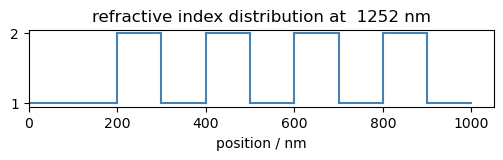

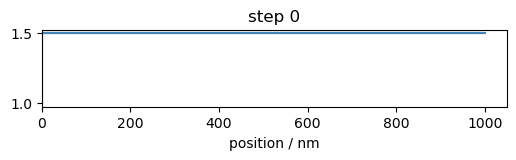

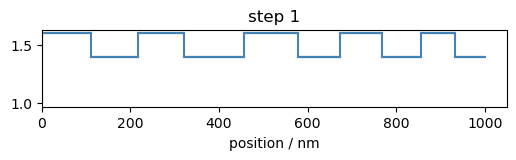

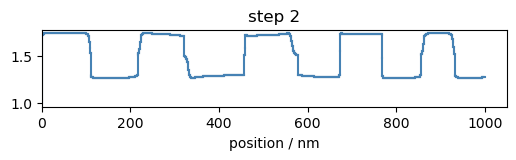

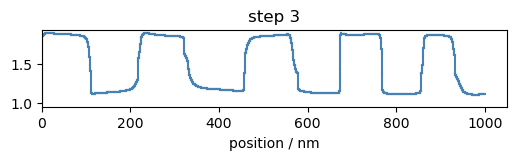

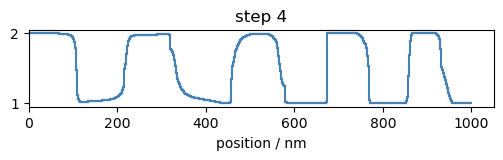

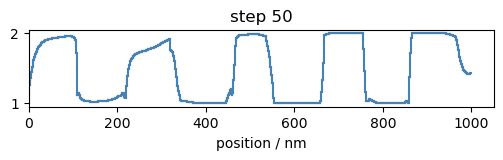

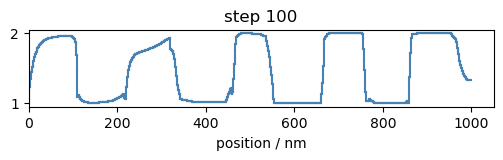

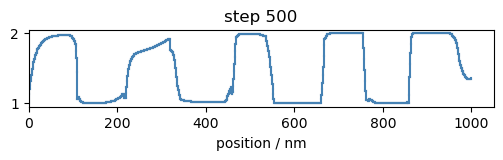

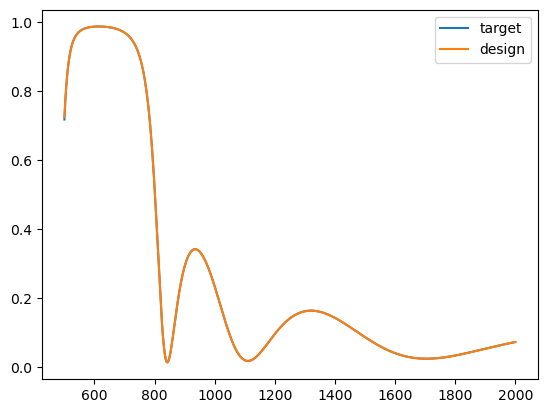

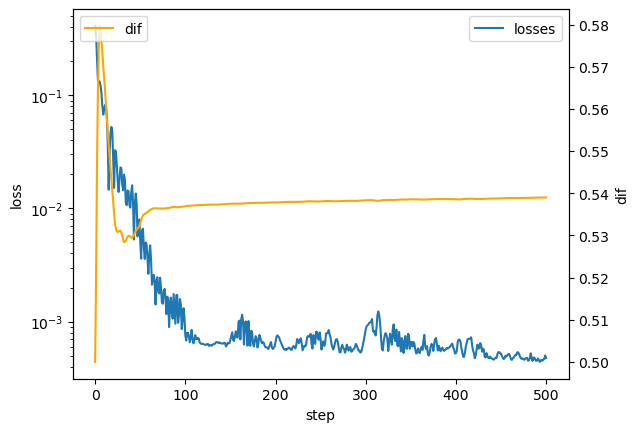

In [37]:

from analyze_utils.structure import plot_layer_thickness

plot_layer_thickness(target_film)
for i in list(range(5)) + [50, 100, 500]:
    ax, _ = plot_layer_thickness(films[i])
    ax.set_title(f'step {i}')

fig, ax = plt.subplots(1, 1)
ax.plot(wls, target_film.get_spec().get_R(), label='target')
free_film.calculate_spectrum()
ax.plot(wls, free_film.get_spec().get_R(), label='design')
ax.legend()

fig, ax = plt.subplots(1, 1)
ax.plot(losses, label='losses')
ax2 = ax.twinx()
ax2.plot(similarities, label='dif', c='orange')
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax2.set_ylabel('dif')
ax.set_yscale('log')

ax.legend(loc='upper right')
ax2.legend(loc='upper left')